In [56]:
# Look at one period problem, alpha=alphal or alphah forever
# Money and cc, only buyers (no hodlers)
# For cc to be accepted in stst, need gammac<alpha*gammam-(1-alpha)(1-B)
# To start with, make alphh=1, alphl st cc always accepted
# Set U(X)=Cln(x); u(q)=((q+b)**(1-eta)-b**eta)/(1-eta); c(q)=q; b=.0001 (Zhang 2014)
# So u'=(q+b)**-eta; c'=1; z(q)=(1-theta)u(q)+theta*c(q); z'=(1-theta)*(q+b)**(-eta)+theta;
# l=theta*(u'(q)-c'(q))/z'(q)
# l=theta*((q+b)**(-eta)-1)/((1-theta)*(q+b)**(-eta)+theta)=theta*(1-(q-b)**eta)/(1-theta*(1-(q+b)**eta))
import math
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
file=r'C:\Users\spspi\Dropbox\Documents\Cryptocurrency Project\Simulations' #Save simulation graphs here
b=.1
B=.95 # Discount rate beta
lam=.75 # Meeting rate lambda
theta=.75 # Buyer bargaining power
eta=2 # Buyer risk aversion
gammam=0.02 # Money inflation rate
gammac=0 # CC inflation rate
alphal=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
alphah=(1+alphal)/2 # Don't want it to be 1, or money is not valued
qstar=1-b # Value at which u'=c'
# Normalize initial price of cc and supplies of currencies
M=1 # Initial Money supply
C=1 # Initial cc supply

# First, need to find steady state prices. Assume enite wealth always spent.
# phi/(phi'B)-1=(1+gammam)/B=i_m=lamb*l(phi'm'+psi'c')+lamm*l(phi'm')=lamb*l(qb)+lamm*l(gm)
# psi/(psi'B)-1=(1+gammac)/B=i_c=lamb*l(phi'm'+psi'c')=lamm*l(qb)

# Create a function that finds tomorrow's q's in stst
def ststq(alpha,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta):
    lamb=lam*alpha
    lamm=lam*(1-alpha)
    qb=np.minimum(np.maximum(((theta*B*lamb-(1-theta)*(1+gammac-B))/theta/(1+gammac-B+B*lamb))**(1/eta)-b,0),qstar)
    qm=np.minimum(np.maximum(((theta*B*lamm-(1-theta)*(gammam-gammac))/theta/(gammam-gammac+B*lamm))**(1/eta)-b,0),qstar)
    return qb,qm

# Create a function that finds tomorrow's price in stst
def ststprices(alpha,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta):
    qb,qm=ststq(alpha,Mp,Cp,gammam,gammac,lam,theta,eta)
    phip=(theta*qm+(1-theta)*((qm+b)**(1-eta)-b**(1-eta))/(1-eta))/Mp
    psip=(theta*(qb-qm)+(1-theta)*((qb+b)**(1-eta)-(qm+b)**(1-eta))/(1-eta))/Cp
    return phip, psip    

# Create an explicit utility function so q is never negative
def u(q,eta=eta):
    if q<0:
        return -1e6
    else:
        return ((q+b)**(1-eta)-b**(1-eta))/(1-eta)
    
# Create a function that outputs z(q(w))=w for a given wealth w and q (solve by giving a w, set this equal to 0, and solve for q)
def wminz(q,w,eta=eta):
    return w-theta*q+(1-theta)*u(q,eta)

# Create a function to take the derivative of z
def dz(q):
    return theta+(1-theta)*(q+b)**(-eta)

# Create a function to solve for q given w (sensitive to first guess)
def qwealth(w):
    def temp(q,w):
        return np.array(dz(q))
    return np.minimum(np.maximum(optimize.root(wminz,0.1,args=w,method='hybr',jac=temp).x,0),qstar)

# Create a function that outputs liquidity for a given q
def liquidityq(q):
    if q>=0:
        return (theta*(1-(q+b)**eta))/(1-theta*(1-(q+b)**eta))
    else:
        return -1e6

# Create a function to solve for q given w and output liquidity 
def liquidity(w):    
    return np.maximum(liquidityq(qwealth(w)),0)

# Create a function to take the derivative of liquidity
def dliq(q):
    return -theta*eta*(q+b)**(eta-1)/(1-theta*(1-(q+b)**eta))**2

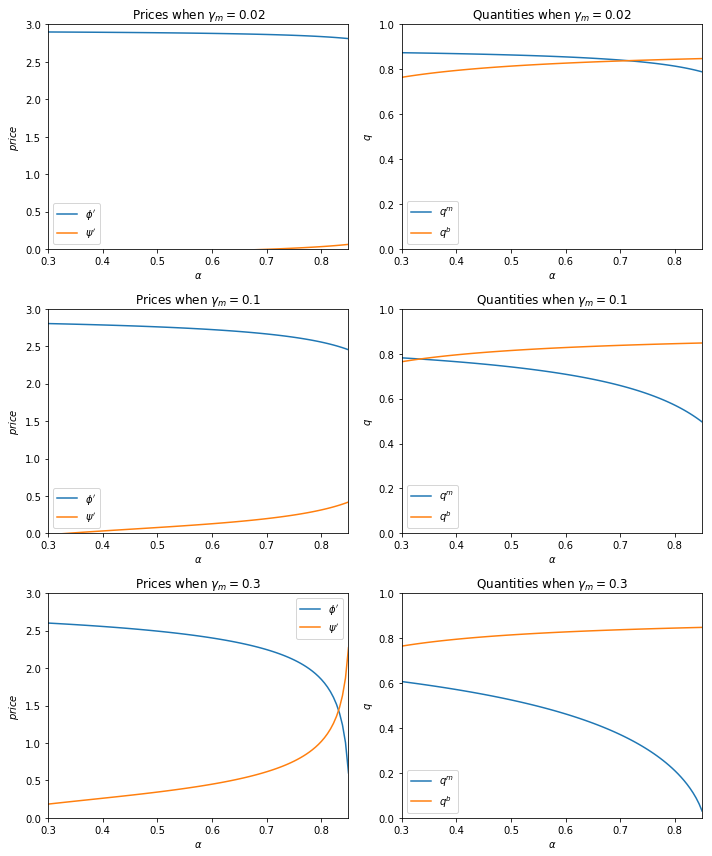

In [78]:
# How does stst look when we change parameters?
# First change alpha, see how this looks for different gammam
Mp=1
Cp=1
top=.85
alphagrid=np.linspace(alphal,top,101)
gammamgrid=[.02,.1,.3]
#gammamgrid=[.02,.1] # If I only want to graph gammam=.02 and gammam=.1
fig,axes=plt.subplots(len(gammamgrid),2,figsize=(10,12))
for j,gammam in enumerate(gammamgrid):
    phipgrid=[]
    psipgrid=[]
    qbgrid=[]
    qmgrid=[]
    for alpha in alphagrid:
            phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam)
            phipgrid.append(phiptemp), psipgrid.append(psiptemp)
            qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam)
            qbgrid.append(qbtemp),qmgrid.append(qmtemp) 


    
    axes[j,0].plot(alphagrid,phipgrid,label="$\phi'$")
    axes[j,0].plot(alphagrid,psipgrid,label="$\psi'$")
    axes[j,0].legend()
    axes[j,0].set_title(f"Prices when $\gamma_m={gammam}$")
    axes[j,0].set_xlabel(r"$\alpha$")
    axes[j,0].set_xlim(alphal,top)
    axes[j,0].set_ylabel("$price$")
    axes[j,0].set_ylim(0,3)
    axes[j,1].plot(alphagrid,qmgrid,label="$q^m$")
    axes[j,1].plot(alphagrid,qbgrid,label="$q^b$")
    axes[j,1].legend()
    axes[j,1].set_title(f"Quantities when $\gamma_m={gammam}$")
    axes[j,1].set_xlabel(r"$\alpha$")
    axes[j,1].set_xlim(alphal,top)
    axes[j,1].set_ylabel("$q$")    
    axes[j,1].set_ylim(0,1)

plt.tight_layout()
# plt.savefig(file+r'\steadystate\ststalphgamm.pdf') If I want to save figures
# plt.savefig(file+r'\steadystate\ststalphgamm2.pdf') If I want to save figures (used with only gammmam=.02 and .1)
plt.show()


In [94]:
# Just change gammam
alpha=.85
gammamgrid=np.linspace(.01,.31,101)
Mp=1
Cp=1
phip,psip,qb,qm=[],[],[],[]
for gammam in gammamgrid:
    phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam)
    phip.append(phiptemp), psip.append(psiptemp)
    qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam)
    qb.append(qbtemp),qm.append(qmtemp)
    
fig1,axes1=plt.subplots(1,2)
axes1[0].plot(gammamgrid,phip,label="$\phi'$")
axes1[0].plot(gammamgrid,psip,label="$\psi'$")
axes1[0].legend()
axes1[0].set_title(r"Prices given $\gamma_m$")
axes1[0].set_xlabel(r"$\gamma_m$")
axes1[0].set_xlim(0,.31)
axes1[0].set_ylabel("$price$")
axes1[1].plot(gammamgrid,qm,label="$q^m$")
axes1[1].plot(gammamgrid,qb,label="$q^b$")
axes1[1].legend()
axes1[1].set_title(r"Quantities given $\gamma_m$")
axes1[1].set_xlabel(r"$\gamma_m$")
axes1[1].set_xlim(0,.31)
axes1[1].set_ylabel("$q$")    
axes1[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\steadystate\ststgammam.pdf')
plt.close()

In [12]:
# Just change gammac
alpha=.85
gammam=.31
gammacgrid=np.linspace(0,.25,101)
Mp=1
Cp=1
phip,psip,qb,qm=[],[],[],[]
for gammac in gammacgrid:
    phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam,gammac=gammac)
    phip.append(phiptemp), psip.append(psiptemp)
    qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam,gammac=gammac)
    qb.append(qbtemp),qm.append(qmtemp)
    
fig1,axes1=plt.subplots(1,2)
axes1[0].plot(gammacgrid,phip,label="$\phi'$")
axes1[0].plot(gammacgrid,psip,label="$\psi'$")
axes1[0].legend()
axes1[0].set_title(r"Prices given $\gamma_c$")
axes1[0].set_xlabel(r"$\gamma_c$")
axes1[0].set_xlim(0,.25)
axes1[0].set_ylabel("$price$")
axes1[1].plot(gammacgrid,qm,label="$q^m$")
axes1[1].plot(gammacgrid,qb,label="$q^b$")
axes1[1].legend()
axes1[1].set_title(r"Quantities given $\gamma_c$")
axes1[1].set_xlabel(r"$\gamma_c$")
axes1[1].set_xlim(0,.25)
axes1[1].set_ylabel("$q$")    
axes1[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\steadystate\ststgammac.pdf')
plt.close()

In [27]:
# Now for alpha=.9, gammam=.1, how does price and quantity change with lambda, eta and theta? Graph all separate for 
# presentations
alpha=.6
alphal=(gammac+1-B)/(gammam+1-B) # Slightly above indifference condition
gammam=.1
Mp=1
Cp=1
thetagrid=np.linspace(0,1,101)
etagrid=np.linspace(.05,3,101) # Make sure 1 is not selected
lamgrid=np.linspace(0,1,101)
alphagrid=np.linspace(alphal,.97,101) # For graphing
phiptheta,psiptheta,qbtheta,qmtheta=[],[],[],[]
phipeta,psipeta,qbeta,qmeta=[],[],[],[]
phiplam,psiplam,qblam,qmlam=[],[],[],[]
phipalpha,psipalpha,qbalpha,qmalpha=[],[],[],[]

for theta in thetagrid:
    phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam,theta=theta)
    phiptheta.append(phiptemp), psiptheta.append(psiptemp)
    qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam,theta=theta)
    qbtheta.append(qbtemp),qmtheta.append(qmtemp)

for eta in etagrid:
    phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam,eta=eta)
    phipeta.append(phiptemp), psipeta.append(psiptemp)
    qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam,eta=eta)
    qbeta.append(qbtemp),qmeta.append(qmtemp)
    
for lam in lamgrid:
    phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam,lam=lam)
    phiplam.append(phiptemp), psiplam.append(psiptemp)
    qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam,lam=lam)
    qblam.append(qbtemp),qmlam.append(qmtemp)
    
for alpha in alphagrid:
    phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam)
    phipalpha.append(phiptemp), psipalpha.append(psiptemp)
    qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam)
    qbalpha.append(qbtemp),qmalpha.append(qmtemp)


fig1,axes1=plt.subplots(1,2)
axes1[0].plot(thetagrid,phiptheta,label="$\phi'$")
axes1[0].plot(thetagrid,psiptheta,label="$\psi'$")
axes1[0].legend()
axes1[0].set_title(r"Prices given $\theta$")
axes1[0].set_xlabel(r"$\theta$")
axes1[0].set_xlim(0,1)
axes1[0].set_ylabel("$Price$")
axes1[1].plot(thetagrid,qmtheta,label="$q^m$")
axes1[1].plot(thetagrid,qbtheta,label="$q^b$")
axes1[1].legend()
axes1[1].set_title(r"Quantities given $\theta$")
axes1[1].set_xlabel(r"$\theta$")
axes1[1].set_xlim(0,1)
axes1[1].set_ylabel("$q$")    
axes1[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\steadystate\ststtheta.pdf')
plt.close()

fig2,axes2=plt.subplots(1,2)
axes2[0].plot(etagrid,phipeta,label="$\phi'$")
axes2[0].plot(etagrid,psipeta,label="$\psi'$")
axes2[0].legend()
axes2[0].set_title(r"Prices given $\eta$")
axes2[0].set_xlabel(r"$\eta$")
axes2[0].set_xlim(.05,3)
axes2[0].set_ylabel("$Price$")
axes2[1].plot(etagrid,qmeta,label="$q^m$")
axes2[1].plot(etagrid,qbeta,label="$q^b$")
axes2[1].legend()
axes2[1].set_title(r"Quantities given $\eta$")
axes2[1].set_xlabel(r"$\eta$")
axes2[1].set_xlim(.05,3)
axes2[1].set_ylabel("$q$")    
axes2[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\steadystate\ststeta.pdf')
plt.close()

fig3,axes3=plt.subplots(1,2)
axes3[0].plot(lamgrid,phiplam,label="$\phi'$")
axes3[0].plot(lamgrid,psiplam,label="$\psi'$")
axes3[0].legend()
axes3[0].set_title(r"Prices given $\lambda$")
axes3[0].set_xlabel(r"$\lambda$")
axes3[0].set_xlim(0,1)
axes3[0].set_ylabel("$Price$")
axes3[1].plot(lamgrid,qmlam,label="$q^m$")
axes3[1].plot(lamgrid,qblam,label="$q^b$")
axes3[1].legend()
axes3[1].set_title(r"Quantities given $\lambda$")
axes3[1].set_xlabel(r"$\lambda$")
axes3[1].set_xlim(0,1)
axes3[1].set_ylabel("$q$")    
axes3[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\steadystate\ststlambda.pdf')
plt.close()

fig4,axes4=plt.subplots(1,2)
axes4[0].plot(alphagrid,phipalpha,label="$\phi'$")
axes4[0].plot(alphagrid,psipalpha,label="$\psi'$")
axes4[0].legend()
axes4[0].set_title(r"Prices given $\alpha$")
axes4[0].set_xlabel(r"$\alpha$")
axes4[0].set_xlim(alphal,1)
axes4[0].set_ylabel("$Price$")
axes4[1].plot(alphagrid,qmalpha,label="$q^m$")
axes4[1].plot(alphagrid,qbalpha,label="$q^b$")
axes4[1].legend()
axes4[1].set_title(r"Quantities given $\alpha$")
axes4[1].set_xlabel(r"$\alpha$")
axes4[1].set_xlim(alphal,1)
axes4[1].set_ylabel("$q$")    
axes4[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\steadystate\ststalpha.pdf')
plt.close()

C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\py

In [127]:
# T={0,1}, mu=1 (no hodlers), so m=Mp/1 and c=Cp/1
gammam=.02
pi=.5 # Probability alpha=alpha0
M=1
C=1
Mp=M*(1+gammam) # tomorrow's money supply
Cp=C*(1+gammac) # tomorrow's cc supply

alpha0=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
alpha1=(alpha0+1)/2# Don't want it to be 1, or money is not valued
lamb0,lamm0=lam*alpha0,lam*(1-alpha0) # Meeting proabilities in low state
lamb1,lamm1=lam*alpha1,lam*(1-alpha1) # Meeting proabilities in high state

phi0s,psi0s=ststprices(alpha0,Mp,Cp,gammam=gammam) # prices in low stst
phi1s,psi1s=ststprices(alpha1,Mp,Cp,gammam=gammam) # prices in high stst
phi0=(B*pi*phi0s*(lamb0*liquidity(phi0s*Mp+psi0s*Cp)+lamm0*liquidity(phi0s*Mp)+1)+ 
     B*(1-pi)*phi1s*(lamb1*liquidity(phi1s*Mp+psi1s*Cp)+lamm1*liquidity(phi1s*Mp)+1))
psi0=B*pi*psi0s*(lamb0*liquidity(phi0s*Mp+psi0s*Cp)+1)+B*(1-pi)*psi1s*(lamb1*liquidity(phi1s*Mp+psi1s*Cp)+1)

print(phi0,psi0)

0.0526315789474 0.0526315789474
0.0210526315789 0.157575757576
2.84988119953 2.78177901477
0.0165036341375 0.0921564388066
2.84307098106 0.0240689146044


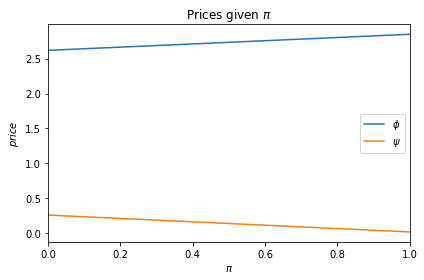

In [128]:
# How do prices and quantities change with pi?
# T={0,1}, mu=1 (no hodlers), so m=Mp/1 and c=Cp/1
gammam=.02
M=1
C=1
Mp=M*(1+gammam) # tomorrow's money supply
Cp=C*(1+gammac) # tomorrow's cc supply

alpha0=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
alpha1=.95 # Don't want it to be 1, or money is not valued
lamb0,lamm0=lam*alpha0,lam*(1-alpha0) # Meeting proabilities in low state
lamb1,lamm1=lam*alpha1,lam*(1-alpha1) # Meeting proabilities in high state

phi0s,psi0s=ststprices(alpha0,Mp,Cp,gammam=gammam) # prices in low stst
phi1s,psi1s=ststprices(alpha1,Mp,Cp,gammam=gammam) # prices in high stst
pigrid=np.linspace(0,1,101)
phigrid,psigrid=[],[]

for pi in pigrid:
    phi0=B*pi*phi0s*(lamb0*liquidity(phi0s*Mp+psi0s*Cp)+lamm0*liquidity(phi0s*Mp)+1)+ \
     B*(1-pi)*phi1s*(lamb1*liquidity(phi1s*Mp+psi1s*Cp)+lamm1*liquidity(phi1s*Mp)+1)
    psi0=B*pi*psi0s*(lamb0*liquidity(phi0s*Mp+psi0s*Cp)+1)+B*(1-pi)*psi1s*(lamb1*liquidity(phi1s*Mp+psi1s*Cp)+1)
    phigrid.append(phi0),psigrid.append(psi0)
    
fig,ax=plt.subplots()
ax.plot(pigrid,phigrid,label="$\phi$")
ax.plot(pigrid,psigrid,label="$\psi$")
ax.legend()
ax.set_title(r"Prices given $\pi$")
ax.set_xlabel(r"$\pi$")
ax.set_xlim(0,1)
ax.set_ylabel("$price$")
#ax.set_ylim(0,3)

plt.tight_layout()
plt.show()

In [72]:
# Run first cell before this one.
# T={0,1}, 0<mu<1 (both buyers and hodlers), so mh=(Mp-mu*m)/(1-mu) and ch=(Cp-mu*c)/(1-mu)
# Two cases, 1. hodlers hold all cc, 2. both hold some cc
# To see if in case 1, solve with c=0. If solution gives mu*m<Mp, then done. If mu*m>Mp, need to solve with c>0
pi=.2 # Chance tomorrow is low state
mu=.98 # share of buyers (vs hodlers)

def periodprices(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mu):
    lambh=lam*alphah # Probability of meeting a both type in high state
    lammh=lam*(1-alphah) # Probability of meeting a money type in high state
    lambl=lam*alphal # Probability of meeting a both type in low state
    lamml=lam*(1-alphal) # Probability of meeting a money type in low state
    # First find out if c'>0 or c'=0
    def test(x):
        firsteqt=x[0]-B*pi*phil*(1+lam*liquidityq(x[3]))-B*(1-pi)*phih*(1+lam*liquidityq(x[4]))
        secondeqt=x[0]-B*phih*(1+lambh*liquidityq(x[5])-lammh*liquidityq(x[6]))
        thirdeqt=wminz(x[3],phil*x[1])
        fourtheqt=wminz(x[4],phih*x[1])
        fiftheqt=wminz(x[5],phih*x[2]+psih*Cp/(1-mu))
        sixtheqt=wminz(x[6],phih*x[2])
        seventheqt=Mp-mu*x[1]-(1-mu)*x[2]
        return [firsteqt, secondeqt, thirdeqt, fourtheqt, fiftheqt, sixtheqt, seventheqt]
    def jact(x):
        return[[1,0,0,-pi*phil*lam*dliq(x[2]),-(1-pi)*phih*lam*dliq(x[3]),0,0],
              [1,0,0,0,0,-phih*lambh*dliq(x[4]),-phih*lammh*dliq(x[5])],
              [0,phil,0,-dz(x[2]),0,0,0],
              [0,phih,0,0,-dz(x[3]),0,0],
              [0,0,phih,0,0,-dz(x[4]),0],
              [0,0,phih,0,0,0,-dz(x[5])],
              [0,-mu,-(1-mu),0,0,0,0]]
    phi,m,mh,ql,qh,qhb,qhm=optimize.fsolve(test,(.5,Mp,Mp,.75,.25,.75,.25),fprime=jact,factor=.1)
    if pi*(psih-psil)>=pi*psil*lambl*liquidityq(ql)+(1-pi)*psih*lambh*liquidityq(qh)-psih*lambh*liquidityq(qhb):
        c,ch=0,Cp/(1-mu)
        psi=B*psih*(1+lambh*liquidityq(qhb))
        return phi,psi,m,mh,c,ch,ql,ql,qh,qh,qhb,qhm
    else:
        def sysc(x):
            firsteq=x[0]-B*pi*phil*(1+lambl*liquidityq(x[6])+lamml*liquidityq(x[7]))- \
                    B*(1-pi)*phih*(1+lambh*liquidityq(x[8])+lammh*liquidityq(x[9]))
            secondeq=x[1]-B*pi*psil*(1+lambl*liquidityq(x[6]))-B*(1-pi)*psih*(1+lambh*liquidityq(x[8])) 
            thirdeq=x[0]-B*phih*(1+lambh*liquidityq(x[10])+lammh*liquidityq(x[11]))
            fourtheq=x[1]-B*psih*(1+lambh*liquidityq(x[10]))
            fiftheq=wminz(x[6],phil*x[2]+psil*x[3])
            sixtheq=wminz(x[7],phil*x[2])
            seventheq=wminz(x[8],phih*x[2]+psih*x[3])
            eigtheq=wminz(x[9],phih*x[2])
            nintheq=wminz(x[10],phih*x[4]+psih*x[5])
            tentheq=wminz(x[11],phih*x[4])
            eleventheq=Mp-mu*x[2]+x[4]*(1-mu)
            tweltheq=Cp-mu*x[3]+x[5]*(1-mu)
            return [firsteq, secondeq, thirdeq, fourtheq, fiftheq, sixtheq, seventheq, eigtheq, nintheq, tentheq, eleventheq, 
                    tweltheq]
        def jac(x):
            return [[1,0,0,0,0,0,-B*pi*phil*lambl*dliq(x[6]),-B*pi*phil*lamml*dliq(x[7]),-B*(1-pi)*phih*lambh*dliq(x[8]),
                    -B*(1-pi)*phih*lammh*dliq(x[9]),0,0],
                   [0,1,0,0,0,0,-B*pi*psil*lambl*dliq(x[7]),0,-B*(1-pi)*psih*lambh*dliq(x[9]),0,0,0],
                   [1,0,0,0,0,0,0,0,0,0,-B*phih*lambh*dliq(x[10]),-B*phih*lammh*dliq(x[11])],
                   [0,1,0,0,0,0,0,0,0,0,-B*psih*lambh*dliq(x[10]),0],
                   [0,0,phil,psil,0,0,-dz(x[4]),0,0,0,0,0],
                   [0,0,phil,0,0,0,0,-dz(x[5]),0,0,0,0],
                   [0,0,phih,psih,0,0,0,0,-dz(x[6]),0,0,0],
                   [0,0,phih,0,0,0,0,0,0,-dz(x[7]),0,0],
                   [0,0,0,0,phih,psih,0,0,0,0,-dz(x[8]),0],
                   [0,0,0,0,phih,0,0,0,0,0,0,-dz(x[9])],
                   [0,0,-mu,-(1-mu),0,0,0,0,0,0,0,0],
                   [0,0,0,-mu,-(1-mu),0,0,0,0,0,0,0]]
        return optimize.fsolve(sysc,(.25,.25,Mp,Mp,Cp,Cp,.75,.75,.75,.75,.75,.75),fprime=jac,factor=.1)

In [75]:
# Test out formulas
gammam=.15
alphal=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
alphah=(1+alphal)/2 # Don't want it to be 1, or money is not valued
pi=.1
mu=.98
M0=1 # Original money supply
C0=1 # Original cc supply
Mp=M0*(1+gammam)**(time+1) # the money supply next period
Cp=C0*(1+gammac)**(time+1) # the cc supply next period
phil,psil=ststprices(alphal,Mp,Cp,gammam=gammam) # prices in low stst
phih,psih=ststprices(alphah,Mp,Cp,gammam=gammam) # prices in high stst
phi,psi,m,mh,c,ch,ql,ql,qh,qh,qhb,q=periodprices(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mu)
print(phi,psi,m,mh,c,ch,ql,ql,qh,qh,qhb,q)
print(Mp-mu*m-(1-mu)*mh)
print(Cp-mu*c-(1-mu)*ch)

0.580973373873 0.120772331033 1.1767903515 2.44501515794 0.250599705434 69.8251446831 7.03601717736 7.03601717736 6.83372249359 6.83372249359 27.8627928615 4.00805427584
-0.0521548476248
-0.642090604988


C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [76]:
# Now graph how prices and curreny holdings change for 1 period growth
# Change mu, alphal, alphah, gammam, pi
# Default Settings
M0=1 # Original money supply
C0=.1 # Original cc supply
pi=.1 # Chance tomorrow is low state
gammam=.15 # inflation of money
gammac=0
time=0 # period problem solved in
mu=.98 # share of buyers (vs hodlers)
alphal=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
alphah=(1+alphal)/2 # Don't want it to be 1, or money is not valued
Mp=M0*(1+gammam)**(time+1) # the money supply next period
Cp=C0*(1+gammac)**(time+1) # the cc supply next period
phil,psil=ststprices(alphal,Mp,Cp,gammam=gammam) # prices in low stst
phih,psih=ststprices(alphah,Mp,Cp,gammam=gammam) # prices in high stst

mugrid=np.linspace(.01,.99,101)
alphalgrid=np.linspace((gammac+1-B)/(gammam+1-B)+.05,(1+alphal)/2-.05,101)
alphahgrid=np.linspace((gammac+1-B)/(gammam+1-B)+.05,.99,101)
gammamgrid=np.linspace(gammam,.25,101)
pigrid=np.linspace(.01,.99,101)

phimu,psimu,mmu,mhmu,cmu,chmu=[],[],[],[],[],[]
phial,psial,mal,mhal,cal,chal=[],[],[],[],[],[]
phiah,psiah,mah,mhah,cah,chah=[],[],[],[],[],[]
phigm,psigm,mgm,mhgm,cgm,chgm=[],[],[],[],[],[]
phipi,psipi,mpi,mhpi,cpi,chpi=[],[],[],[],[],[]

for mui in mugrid:
    phi,psi,m,mh,c,ch,ql,ql,qh,qh,qhb,qhm=periodprices(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mui)
    phimu.append(phi),psimu.append(psi),mmu.append(m),mhmu.append(mh),cmu.append(c),chmu.append(ch)
    
for al in alphalgrid:
    philt,psilt=ststprices(al,Mp,Cp,gammam=gammam)
    phi,psi,m,mh,c,ch,ql,ql,qh,qh,qhb,qhm=periodprices(al,alphah,philt,psilt,phih,psih,Mp,Cp,pi=pi,mu=mu)
    phial.append(phi),psial.append(psi),mal.append(m),mhal.append(mh),cal.append(c),chal.append(ch)
    
for ah in alphahgrid:
    phiht,psiht=ststprices(ah,Mp,Cp,gammam=gammam)
    phi,psi,m,mh,c,ch,ql,ql,qh,qh,qhb,qhm=periodprices(alphal,ah,phil,psil,phiht,psiht,Mp,Cp,pi=pi,mu=mu)
    phiah.append(phi),psiah.append(psi),mah.append(m),mhah.append(mh),cah.append(c),chah.append(ch)
    
for gm in gammamgrid:
    philt,psilt=ststprices(alphal,Mp,Cp,gammam=gm)
    phiht,psiht=ststprices(alphah,Mp,Cp,gammam=gm)
    phi,psi,m,mh,c,ch,ql,ql,qh,qh,qhb,qhm=periodprices(alphal,alphah,philt,psilt,phiht,psiht,Mp,Cp,pi=pi,mu=mu)
    phigm.append(phi),psigm.append(psi),mgm.append(m),mhgm.append(mh),cgm.append(c),chgm.append(ch)
    
for pii in pigrid:
    phi,psi,m,mh,c,ch,ql,ql,qh,qh,qhb,qhm=periodprices(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pii,mu=mu)
    phipi.append(phi),psipi.append(psi),mpi.append(m),mhpi.append(mh),cpi.append(c),chpi.append(ch)
    
fig1,axes1=plt.subplots(1,2)
axes1[0].plot(mugrid,phimu,label="$\phi$")
axes1[0].plot(mugrid,psimu,label="$\psi$")
axes1[0].legend()
axes1[0].set_title(r"Prices given $\mu$")
axes1[0].set_xlabel(r"$\mu$")
axes1[0].set_xlim(0,1)
axes1[0].set_ylabel("$Price$")
axes1[1].plot(mugrid,mmu,label=r"$m'$")
axes1[1].plot(mugrid,mhmu,label=r"$\tilde{m}'$")
axes1[1].plot(mugrid,cmu,label=r"$c'$")
axes1[1].plot(mugrid,chmu,label=r"$\tilde{c}'$")
axes1[1].legend()
axes1[1].set_title(r"Portfolios given $\mu$")
axes1[1].set_xlabel(r"$\mu$")
axes1[1].set_xlim(0,1)
axes1[1].set_ylabel("Currency Holdings") 


plt.tight_layout()
plt.savefig(file+r'\oneperiod\1pmu.pdf')
plt.close()

fig2,axes2=plt.subplots(1,2)
axes2[0].plot(alphalgrid,phial,label="$\phi$")
axes2[0].plot(alphalgrid,psial,label="$\psi$")
axes2[0].legend()
axes2[0].set_title(r"Prices given $\alpha_0$")
axes2[0].set_xlabel(r"$\alpha_0$")
axes2[0].set_xlim((gammac+1-B)/(gammam+1-B)+.05,(1+alphal)/2-.05)
axes2[0].set_ylabel("$Price$")
axes2[1].plot(alphalgrid,mal,label=r"$m'$")
axes2[1].plot(alphalgrid,mhal,label=r"$\tilde{m}'$")
axes2[1].plot(alphalgrid,cal,label=r"$c'$")
axes2[1].plot(alphalgrid,chal,label=r"$\tilde{c}'$")
axes2[1].legend()
axes2[1].set_title(r"Portfolios given $\alpha_0$")
axes2[1].set_xlabel(r"$\alpha_0$")
axes2[1].set_xlim((gammac+1-B)/(gammam+1-B)+.05,(1+alphal)/2-.05)
axes2[1].set_ylabel("Currency Holdings") 

plt.tight_layout()
plt.savefig(file+r'\oneperiod\1pa0.pdf')
plt.close()

fig3,axes3=plt.subplots(1,2)
axes3[0].plot(alphahgrid,phiah,label="$\phi$")
axes3[0].plot(alphahgrid,psiah,label="$\psi$")
axes3[0].legend()
axes3[0].set_title(r"Prices given $\alpha_1$")
axes3[0].set_xlabel(r"$\alpha_1$")
axes3[0].set_xlim((gammac+1-B)/(gammam+1-B)+.05,1)
axes3[0].set_ylabel("$Price$")
axes3[1].plot(alphahgrid,mah,label=r"$m'$")
axes3[1].plot(alphahgrid,mhah,label=r"$\tilde{m}'$")
axes3[1].plot(alphahgrid,cah,label=r"$c'$")
axes3[1].plot(alphahgrid,chah,label=r"$\tilde{c}'$")
axes3[1].legend()
axes3[1].set_title(r"Portfolios given $\alpha_1$")
axes3[1].set_xlabel(r"$\alpha_1$")
axes3[1].set_xlim((gammac+1-B)/(gammam+1-B)+.05,1)
axes3[1].set_ylabel("Currency Holdings") 

plt.tight_layout()
plt.savefig(file+r'\oneperiod\1pa1.pdf')
plt.close()

fig4,axes4=plt.subplots(1,2)
axes4[0].plot(gammamgrid,phigm,label="$\phi$")
axes4[0].plot(gammamgrid,psigm,label="$\psi$")
axes4[0].legend()
axes4[0].set_title(r"Prices given $\gamma_m$")
axes4[0].set_xlabel(r"$\gamma_m$")
axes4[0].set_xlim(gammam,.25)
axes4[0].set_ylabel("$Price$")
axes4[1].plot(gammamgrid,mgm,label=r"$m'$")
axes4[1].plot(gammamgrid,mhgm,label=r"$\tilde{m}'$")
axes4[1].plot(gammamgrid,cgm,label=r"$c'$")
axes4[1].plot(gammamgrid,chgm,label=r"$\tilde{c}'$")
axes4[1].legend()
axes4[1].set_title(r"Portfolios given $\gamma_m$")
axes4[1].set_xlabel(r"$\gamma_m$")
axes4[1].set_xlim(gammam,.25)
axes4[1].set_ylabel("Currency Holdings") 

plt.tight_layout()
plt.savefig(file+r'\oneperiod\1pgm.pdf')
plt.close()

fig5,axes5=plt.subplots(1,2)
axes5[0].plot(pigrid,phipi,label="$\phi$")
axes5[0].plot(pigrid,psipi,label="$\psi$")
axes5[0].legend()
axes5[0].set_title(r"Prices given $\pi$")
axes5[0].set_xlabel(r"$\pi$")
axes5[0].set_xlim(0,1)
axes5[0].set_ylabel("$Price$")
axes5[1].plot(pigrid,mpi,label=r"$m'$")
axes5[1].plot(pigrid,mhpi,label=r"$\tilde{m}'$")
axes5[1].plot(pigrid,cpi,label=r"$c'$")
axes5[1].plot(pigrid,chpi,label=r"$\tilde{c}'$")
axes5[1].legend()
axes5[1].set_title(r"Portfolios given $\pi$")
axes5[1].set_xlabel(r"$\pi$")
axes5[1].set_xlim(0,1)
axes5[1].set_ylabel("Currency Holdings")  

plt.tight_layout()
plt.savefig(file+r'\oneperiod\1ppi.pdf')
plt.close()

# One more plot to check if graphs are clearing currency markets
figmc,axesmc=plt.subplots(3,2)
axesmc[0,0].plot(mugrid,Mp-np.asarray(mugrid)*np.asarray(mmu)-(1-np.asarray(mugrid))*np.asarray(mhmu))
axesmc[0,0].plot(mugrid,Cp-np.asarray(mugrid)*np.asarray(cmu)-(1-np.asarray(mugrid))*np.asarray(chmu))
axesmc[0,0].legend()
axesmc[0,0].set_xlabel(r"$\mu$")
axesmc[0,0].set_xlim(0,1)
axesmc[0,0].set_ylabel("Difference")

axesmc[0,1].plot(alphalgrid,Mp-mu*np.asarray(mal)-(1-mu)*np.asarray(mhal))
axesmc[0,1].plot(alphalgrid,Cp-mu*np.asarray(cal)-(1-mu)*np.asarray(chal))
axesmc[0,1].legend()
axesmc[0,1].set_xlabel(r"$\alpha_0$")
axesmc[0,1].set_xlim((gammac+1-B)/(gammam+1-B)+.05,(1+alphal)/2-.05)
axesmc[0,1].set_ylabel("Difference") 

axesmc[1,0].plot(alphahgrid,Mp-mu*np.asarray(mah)-(1-mu)*np.asarray(mhah))
axesmc[1,0].plot(alphahgrid,Cp-mu*np.asarray(cah)-(1-mu)*np.asarray(chah))
axesmc[1,0].legend()
axesmc[1,0].set_xlabel(r"$\alpha_1$")
axesmc[1,0].set_xlim((gammac+1-B)/(gammam+1-B)+.05,1)
axesmc[1,0].set_ylabel("Difference") 

axesmc[1,1].plot(gammamgrid,Mp-mu*np.asarray(mgm)-(1-mu)*np.asarray(mhgm))
axesmc[1,1].plot(gammamgrid,Cp-mu*np.asarray(cgm)-(1-mu)*np.asarray(chgm))
axesmc[1,1].legend()
axesmc[1,1].set_xlabel(r"$\gamma_m$")
axesmc[1,1].set_xlim(gammam,.25)
axesmc[1,1].set_ylabel("Difference") 

axesmc[2,0].plot(pigrid,Mp-mu*np.asarray(mpi)-(1-mu)*np.asarray(mhpi))
axesmc[2,0].plot(pigrid,Cp-mu*np.asarray(cpi)-(1-mu)*np.asarray(chpi))
axesmc[2,0].legend()
axesmc[2,0].set_xlabel(r"$\pi$")
axesmc[2,0].set_xlim(0,1)
axesmc[2,0].set_ylabel("Difference")

plt.tight_layout()
plt.savefig(file+r'\oneperiod\1MC.pdf')
plt.close()

C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in maximum
C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in minimum
C:\Users\spspi\AppData\Local

<class 'float'> <class 'list'>
[-1.43215362 -1.4373184  -1.442495   -1.4476835  -1.45288399 -1.45809654
 -1.46332125 -1.4685582  -1.47380748 -1.47906917 -1.48434338 -1.48963019
 -1.4949297  -1.50024199 -1.50556716 -1.51090531 -1.51625654 -1.52162094
 -1.52699862 -1.53238968 -1.53779421 -1.54321233 -1.54864414 -1.55408974
 -1.55954925 -1.56502278 -1.57051043 -1.57601232 -1.58152857 -1.58705929
 -1.59260461 -1.59816464 -1.6037395  -1.60932932 -1.61493422 -1.62055434
 -1.62618979 -1.63184073 -1.63750726 -1.64318955 -1.64888772 -1.65460191
 -1.66033226 -1.66607893 -1.67184205 -1.67762179 -1.68341828 -1.68923169
 -1.69506218 -1.7009099  -1.70677502 -1.7126577  -1.71855812 -1.72447643
 -1.73041283 -1.73636749 -1.74234058 -1.74833229 -1.75434282 -1.76037234
 -1.76642106 -1.77248918 -1.77857688 -1.78468439 -1.79081191 -1.79695964
 -1.80312782 -1.80931666 -1.81552638 -1.82175721 -1.8280094  -1.83428317
 -1.84057876 -1.84689644 -1.85323644 -1.85959903 -1.86598447 -1.87239302
 -1.87882496 -1.8852